# Density and layering analysis
*Josh King, Environment and Climate Change Canada, 2019*

Analysis of the SMP derived snow density and layering products


In [2]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import gridspec
plt.rcParams["font.family"] = "Times New Roman"
import pickle
from scipy.stats import mode
import geopandas as gpd
from shapely.geometry import Point
from geostatsmodels import utilities, variograms

# Plot settings
axis_value_size = 12
axis_label_size = 14

In [3]:
# Import classified SMP profiles and density
site_path = './output/sites'
summary_files = []
for i in os.listdir(site_path):
    if os.path.isfile(os.path.join(site_path,i)) and 'Summary' in i:
        summary_files.append(os.path.join(site_path, i))
        
data_files = []
for i in os.listdir(site_path):
    if os.path.isfile(os.path.join(site_path,i)) and 'Data' in i:
        data_files.append(os.path.join(site_path, i))
        
data_list = []
for filename in data_files:
    df = pd.read_pickle(filename)
    data_list.append(df)

data_df = pd.concat(data_list, axis=0, ignore_index=True)

summary_list = []
for filename in summary_files:
    df = pd.read_pickle(filename)
    summary_list.append(df)

summary_df = pd.concat(summary_list, axis=0, ignore_index=True)
campaign_name = [x.split('_')[0] for x in summary_df['site_name'].values]
summary_df['campaign_name'] = np.array(campaign_name)

# Remove bad measurement rows, this one sliped though but has no penetration
summary_df.drop(summary_df[summary_df['file_name'] == 'S34M0399'].index, inplace = True)
summary_df.head(1)

,file_name,site_name,ice_type,latitude,longitude,penetration,density_f,density_h,density_r,fraction_f,fraction_h,fraction_r,mean_weighted_density,campaign_name
0,S34M1840,Alert_2_MYI,MYI,83.983345,-66.351509,501.816095,351.309129,233.568333,319.221392,0.368159,0.537313,0.094527,285.012248,Alert


In [4]:
# Site level statistics
np.round(summary_df.groupby('site_name').mean(),4)

,latitude,longitude,penetration,density_f,density_h,density_r,fraction_f,fraction_h,fraction_r,mean_weighted_density
site_name,,,,,,,,,,
Alert_2_MYI,83.9834,-66.3509,442.4535,337.6677,244.7464,338.3663,0.3682,0.5189,0.1129,289.2907
Alert_3_MYI,83.4421,-64.4156,336.4442,322.6734,252.9068,335.7670,0.4251,0.3717,0.2033,302.2975
Alert_5_MYI,84.8578,-69.7044,391.9173,352.6022,275.3634,313.5713,0.6076,0.2743,0.1180,326.4110
Alert_6_MYI,85.4446,-73.4211,344.8151,277.0538,254.5795,262.0742,0.2910,0.5686,0.1404,262.7972
Alert_7_MYI,85.8542,-76.6536,347.3781,233.2082,240.7814,246.7971,0.1483,0.7249,0.1268,240.3345
Alert_8_MYI,86.2848,-80.0690,480.4377,330.9750,261.1728,294.1458,0.2056,0.7124,0.0820,279.6550
Eureka_1_FYI,79.9629,-86.0019,137.8192,363.2124,249.9163,398.1617,0.5366,0.0813,0.3821,370.1622
Eureka_2_FYI,79.9944,-86.4462,172.7160,345.7032,242.6898,381.4227,0.5900,0.0941,0.3158,349.7077
Eureka_3_FYI,80.0785,-86.7794,161.0026,347.3919,261.2056,357.8453,0.5136,0.0865,0.3999,345.2262


In [5]:
# Mean density by campaign and ice type
summary_df.groupby(['campaign_name','ice_type'])['mean_weighted_density'].mean()

campaign_name  ice_type
Alert          MYI         289.625722
Eureka         FYI         326.853445
               MYI         271.837816
Name: mean_weighted_density, dtype: float64

In [6]:
# Count transitions between layer classifications as a proxy for the
# number of layers within each SMP profile

layer_df = pd.DataFrame()
for row in summary_df.iterrows():
    clas = data_df[data_df['file_name'] == row[1].file_name].layer_label.values
    clas[clas =='R'] = 1
    clas[clas =='F'] = 2
    clas[clas =='H'] = 3
    
    layers = np.abs(np.diff(clas))
    layer_top = np.insert(np.ravel(np.argwhere(layers >= 1)),0,0) + 1
    layers_present, type_count = np.unique(clas[layer_top], return_counts=True)
    
    layer_count = np.array([0,0,0])
    for idx, layer_type in enumerate(layers_present):
        layer_count[layer_type-1] = type_count[idx]
    layer_df = layer_df.append(pd.DataFrame([layer_count]), ignore_index=True)
    
layer_df.columns = ['r', 'f', 'h']
layer_df['l_total'] = layer_df.sum(axis=1)
summary_layers = pd.concat([summary_df, layer_df], axis=1)

In [7]:
# Layer count summary by layer type, campaign and ice type
summary_layers.groupby(['campaign_name','ice_type'])['r', 'f', 'h'].describe()

r                                               \
                        count      mean       std  min  25%  50%  75%  max   
campaign_name ice_type                                                       
Alert         MYI        63.0  1.063492  0.245805  1.0  1.0  1.0  1.0  2.0   
Eureka        FYI       403.0  1.079404  0.279743  1.0  1.0  1.0  1.0  3.0   
              MYI       147.0  1.136054  0.381767  1.0  1.0  1.0  1.0  3.0   

                            f            ...                 h            \
                        count      mean  ...  75%   max  count      mean   
campaign_name ice_type                   ...                               
Alert         MYI        63.0  3.174603  ...  4.0  11.0   63.0  3.158730   
Eureka        FYI       403.0  1.898263  ...  2.0   7.0  403.0  1.491315   
              MYI       147.0  2.829932  ...  3.5   8.0  147.0  2.653061   

                                                            
                             std  min  25%  50%  75%   max  
campaign_name ice_type                                      
Alert         MYI       2.041555  1.0  2.0  3.0  4.0  11.0  
Eureka        FYI       1.148999  0.0  1.0  1.0  2.0   7.0  
              MYI       1.427005  1.0  2.0  2.0  3.0   8.0  

[3 rows x 24 columns]

In [8]:
# Layer count summary by campaign and ice type
summary_layers.groupby(['campaign_name','ice_type'])['l_total'].describe()

count      mean       std  min  25%  50%  75%   max
campaign_name ice_type                                                     
Alert         MYI        63.0  7.396825  4.078028  3.0  5.0  7.0  9.0  23.0
Eureka        FYI       403.0  4.468983  2.213910  1.0  3.0  4.0  5.0  15.0
              MYI       147.0  6.619048  2.908027  3.0  5.0  6.0  8.0  17.0

In [9]:
data_max = summary_layers[summary_layers['ice_type'] == 'MYI']['l_total'].max().astype(int)
data_min = 0
bin_size = 1
bins_layers = range(data_min,data_max+bin_size, bin_size)

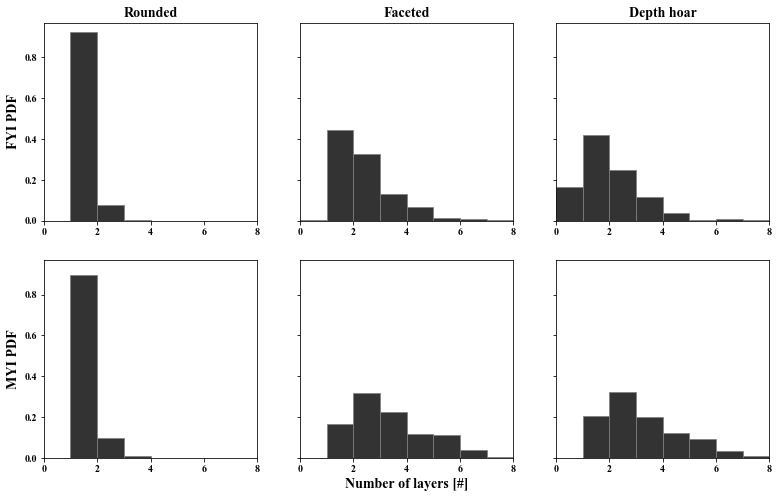

In [10]:
# Paper figure 9 with caption
# ' Number of layers characterized within SMP profiles separated by layer-type classification. 
#   Layers were counted where transitions between layer-type classifications were found in the SMP profiles.'

f, ((ax1, ax2,ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, sharey=True, figsize=(13,8))

hist_kws = dict(bins = bins_layers,  
                edgecolor="grey", 
                alpha = 0.8, grid = False, 
                color = 'black', density = True)


summary_layers[summary_layers['ice_type'] == 'MYI']['r'].hist(ax = ax4, **hist_kws)
summary_layers[summary_layers['ice_type'] == 'FYI']['r'].hist(ax = ax1, **hist_kws)

summary_layers[summary_layers['ice_type'] == 'MYI']['f'].hist(ax = ax5, **hist_kws)
summary_layers[summary_layers['ice_type'] == 'FYI']['f'].hist(ax = ax2, **hist_kws)

summary_layers[summary_layers['ice_type'] == 'MYI']['h'].hist(ax = ax6, **hist_kws)
summary_layers[summary_layers['ice_type'] == 'FYI']['h'].hist(ax = ax3, **hist_kws)


ax1.set_xlim(0,8)
ax2.set_xlim(0,8)
ax3.set_xlim(0,8)

ax1.set_title('Rounded',fontsize=axis_label_size)
ax2.set_title('Faceted',fontsize=axis_label_size)
ax3.set_title('Depth hoar',fontsize=axis_label_size)
ax5.set_xlabel('Number of layers [#]',fontsize=axis_label_size)

ax1.set_ylabel('FYI PDF',fontsize=axis_label_size)
ax4.set_ylabel('MYI PDF',fontsize=axis_label_size)

ax4.set_xlim(0,8)
ax5.set_xlim(0,8)
ax6.set_xlim(0,8)

f.savefig('./output/figures/Fig9_layers_lowres.png', format='png')

In [11]:
# Profile counts by campaign
sub_df = summary_df[summary_df["campaign_name"] == "Alert"]
sub_df.groupby('site_name').count().mean()[0]

10.5

In [12]:
sub_df = summary_df[summary_df["campaign_name"] == "Eureka"]
sub_df.groupby('site_name').count().mean()[0]

68.875

In [13]:
summary_df.describe()

,latitude,longitude,penetration,density_f,density_h,density_r,fraction_f,fraction_h,fraction_r,mean_weighted_density
count,614.000000,614.000000,614.000000,612.000000,546.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,80.463730,-85.047545,238.477305,324.200773,248.567778,331.049635,0.449168,0.298995,0.251836,309.772566
std,1.522407,5.060707,144.530547,45.933697,23.814549,63.100199,0.181375,0.226212,0.151156,44.612923
min,79.812958,-86.810173,4.770661,165.109435,56.935088,165.212308,0.000000,0.000000,0.039370,165.145441
25%,79.963392,-86.791388,134.708672,292.613470,236.059994,290.155234,0.311475,0.083333,0.134848,274.105137
50%,79.982834,-86.785255,192.725199,329.015672,245.928487,346.714436,0.445626,0.281036,0.222222,307.229947
75%,80.022165,-86.297140,328.528912,361.741507,258.062124,378.937856,0.603764,0.484604,0.322124,345.052365
max,86.284805,-64.415154,898.179714,425.440044,352.834628,444.831265,0.895000,0.816176,1.000000,427.897041


In [14]:
# FYI Stats
summary_df[summary_df["ice_type"] == "FYI"].describe()

,latitude,longitude,penetration,density_f,density_h,density_r,fraction_f,fraction_h,fraction_r,mean_weighted_density
count,403.000000,403.000000,403.000000,401.000000,335.000000,403.000000,403.000000,403.000000,403.000000,403.000000
mean,79.980689,-86.694408,181.663352,336.171865,247.495198,351.792717,0.498674,0.197874,0.303451,326.853445
std,0.073047,0.225525,88.009765,42.944847,27.343275,51.073624,0.182274,0.183776,0.152481,41.493822
min,79.842346,-86.805763,4.770661,165.109435,56.935088,165.212308,0.000000,0.000000,0.096154,165.145441
25%,79.966660,-86.791092,121.314045,310.518674,232.887779,327.185764,0.379365,0.048232,0.202074,296.837383
50%,79.993752,-86.785713,166.278919,344.267867,244.702565,362.688243,0.527778,0.133858,0.270270,331.177996
75%,80.021603,-86.779221,227.878090,365.737123,262.876434,386.379213,0.636364,0.329932,0.364510,356.437842
max,80.080154,-85.994820,499.943214,425.440044,344.507339,444.831265,0.895000,0.735849,1.000000,427.897041


In [15]:
# MYI Stats
summary_df[summary_df["ice_type"] == "MYI"].describe()

,latitude,longitude,penetration,density_f,density_h,density_r,fraction_f,fraction_h,fraction_r,mean_weighted_density
count,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000,211.000000
mean,81.386314,-81.902116,346.989263,301.450024,250.270690,291.431331,0.354614,0.492131,0.153254,277.148897
std,2.335027,7.714665,167.700423,42.804577,16.672392,65.010276,0.136898,0.166191,0.085494,29.743145
min,79.812958,-86.810173,62.477270,209.181327,214.044479,166.999265,0.060000,0.048387,0.039370,209.442964
25%,79.813736,-86.807869,210.915280,267.226033,241.026697,242.112306,0.252390,0.375000,0.094486,258.409800
50%,79.982811,-86.291840,353.882217,298.653505,247.188281,287.402931,0.342466,0.517483,0.124183,270.058269
75%,83.442139,-80.068569,464.064030,329.153084,256.339616,349.129328,0.435855,0.615726,0.186795,291.373577
max,86.284805,-64.415154,898.179714,397.644612,352.834628,414.663870,0.780000,0.816176,0.452381,369.124463


In [16]:
# MYI Eureka
summary_df[(summary_df["ice_type"] == "MYI") & (summary_df["campaign_name"] == "Eureka")].describe()

,latitude,longitude,penetration,density_f,density_h,density_r,fraction_f,fraction_h,fraction_r,mean_weighted_density
count,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000,148.000000
mean,79.910790,-86.512522,325.809373,293.612596,247.429345,285.300838,0.348709,0.488608,0.162684,271.837816
std,0.084050,0.255500,183.665182,40.673550,15.404702,63.350032,0.122479,0.156043,0.090216,27.442394
min,79.812958,-86.810173,62.477270,209.181327,214.044479,166.999265,0.060000,0.048387,0.044025,209.442964
25%,79.813622,-86.808023,172.641522,261.622791,239.611246,238.659074,0.252111,0.373355,0.094315,254.650092
50%,79.982334,-86.302647,286.665277,293.281235,245.154568,276.182060,0.343304,0.511923,0.130428,267.958016
75%,79.982895,-86.290064,449.811965,320.081263,251.904886,335.520975,0.427649,0.602834,0.213684,284.423320
max,79.983727,-86.284973,898.179714,385.207641,352.834628,414.663870,0.661290,0.816176,0.452381,369.124463


In [17]:
# MYI Alert
summary_df[(summary_df["ice_type"] == "MYI") & (summary_df["campaign_name"] == "Alert")].describe()

,latitude,longitude,penetration,density_f,density_h,density_r,fraction_f,fraction_h,fraction_r,mean_weighted_density
count,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000
mean,84.852626,-71.071320,396.745195,319.861759,256.945597,305.833124,0.368488,0.500409,0.131103,289.625722
std,1.022082,5.611944,108.123842,42.337661,17.729071,67.076875,0.166228,0.188994,0.068911,31.390357
min,83.442131,-80.069839,107.369830,226.100817,226.825235,171.117690,0.094488,0.096491,0.039370,230.095648
25%,83.983414,-73.421467,328.134284,287.748004,245.863849,250.261407,0.253892,0.401936,0.096517,265.185731
50%,84.857788,-69.704605,393.138413,321.093258,253.926594,319.221392,0.330645,0.537313,0.116959,284.625541
75%,85.444664,-66.350803,484.345021,352.391677,263.889047,367.920188,0.469795,0.630680,0.138819,311.091404
max,86.284805,-64.415154,600.535099,397.644612,301.797640,405.789767,0.780000,0.814286,0.441860,359.723674


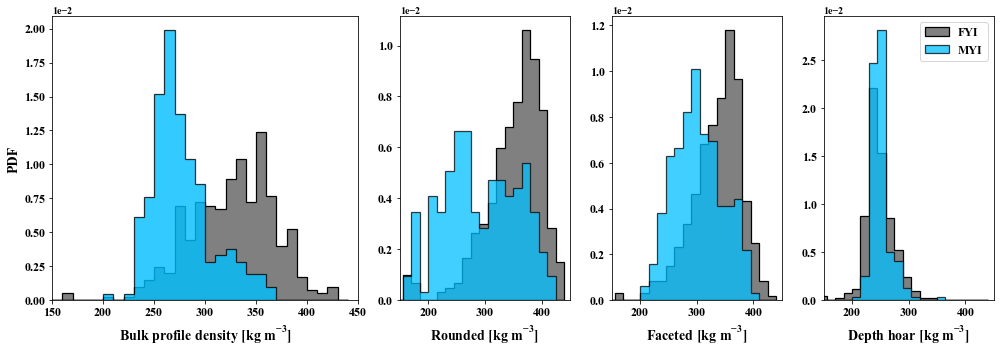

In [18]:
# Figure 7 with caption
# 'Bulk density derived from SMP profiles collected on first year (FYI, n = 403) and multiyear (MYI, n = 211) sea ice (Left). 
#  Automated profile classification was used to separate the high vertical resolution (2.5 mm) estimates of snow density and produce
#  layer-type distributions for rounded, faceted and depth hoar classifications (Right).'

# Histogram bins size
common_bin_all = range(50,450, 10)
common_bin_dens = range(50,450, 15)

fig = plt.figure(figsize=(14, 5)) 
gs = gridspec.GridSpec(1, 4, width_ratios=[1.8, 1, 1, 1]) 


ax0 = plt.subplot(gs[0])


hist_kws = dict(histtype= "stepfilled",
                grid = False,
                edgecolor="black",
                density = True,
                linewidth = 1.25)

summary_df[summary_df["ice_type"] == "FYI"]['mean_weighted_density'] \
        .hist(bins = common_bin_all, color = 'grey', 
              alpha = 1, ax = ax0, label = 'FYI', **hist_kws)

summary_df[summary_df["ice_type"] == "MYI"]['mean_weighted_density'] \
        .hist(bins = common_bin_all, alpha = 0.8, color = 'deepskyblue', ax = ax0, label = 'MYI', **hist_kws)


ax0.set_xlim(150,450)
ax0.set_xlabel('Bulk profile density [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax0.set_ylabel('PDF',fontsize=axis_label_size)
ax0.tick_params(axis='both', which='major', labelsize=axis_value_size)

# TODO: Need to clean up the axis numbering
ax0.ticklabel_format(axis='y',style='sci', scilimits=(1,5), useMathText=False)

ax1 = plt.subplot(gs[1])
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)

summary_df[summary_df["ice_type"] == "FYI"]['density_r'] \
        .hist(bins = common_bin_dens, color = 'grey',  alpha = 1, **hist_kws)

summary_df[summary_df["ice_type"] == "MYI"]['density_r'] \
        .hist(bins = common_bin_dens, color = 'deepskyblue', alpha = 0.75, ax = ax1, **hist_kws)



ax1.set_xlabel('Rounded [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax1.set_xlim(150,450)
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax1.ticklabel_format(axis='y',style='sci', scilimits=(1,5), useMathText=False)



ax2 = plt.subplot(gs[2])


summary_df[summary_df["ice_type"] == "FYI"]['density_f'] \
        .hist(bins = common_bin_dens, color = 'grey',  alpha =1, ax = ax2, **hist_kws)


summary_df[summary_df["ice_type"] == "MYI"]['density_f'] \
        .hist(bins = common_bin_dens, color = 'deepskyblue', ax = ax2,  alpha = 0.75, **hist_kws)


ax2.set_xlabel('Faceted [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax2.set_xlim(150,450)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.ticklabel_format(axis='y',style='sci', scilimits=(1,5), useMathText=False)


ax3 = plt.subplot(gs[3])

summary_df[summary_df["ice_type"] == "FYI"]['density_h'] \
        .hist(bins = common_bin_dens, color = 'grey',  alpha = 1, ax = ax3, label = 'FYI', **hist_kws)

summary_df[summary_df["ice_type"] == "MYI"]['density_h'] \
        .hist(bins = common_bin_dens, color = 'deepskyblue',alpha = 0.75, ax = ax3, label = 'MYI', **hist_kws)

ax3.set_xlabel('Depth hoar [kg m$\mathregular{^{-3}}$]',fontsize=axis_label_size)
ax3.set_xlim(150,450)
ax3.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax3.ticklabel_format(axis='y',style='sci', scilimits=(1,5), useMathText=False)
ax3.legend(loc=0, fontsize=axis_value_size)

plt.tight_layout()
fig.savefig('./output/figures/Fig7_density_dist_lowres.png', format='png')


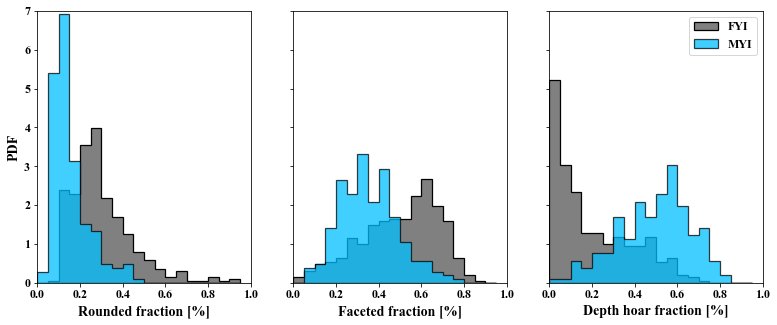

In [19]:
# Figure 8 with caption
# 'Fractional snowpack composition by rounded, faceted, and depth hoar layer types derived 
#  from the SMP transect profiles on first year (FYI) and multiyear (MYI) sea ice.'

common_bin_vol = np.arange(0,1, 0.05)
f, (ax1, ax2,ax3) = plt.subplots(1, 3, sharey=True, figsize=(13,5))

hist_kws = dict(bins = common_bin_vol,
                histtype= "stepfilled",
                grid = False,
                edgecolor="black",
                density = True,
                linewidth = 1.25)

summary_df[summary_df["ice_type"] == "FYI"]['fraction_r'] \
        .hist(color = 'grey', ax = ax1, **hist_kws)

summary_df[summary_df["ice_type"] == "MYI"]['fraction_r'] \
        .hist(color = 'deepskyblue',alpha = 0.75, ax = ax1, **hist_kws)

summary_df[summary_df["ice_type"] == "FYI"]['fraction_f'] \
        .hist(color = 'grey', ax = ax2, **hist_kws)

summary_df[summary_df["ice_type"] == "MYI"]['fraction_f'] \
        .hist(color = 'deepskyblue',alpha = 0.75, ax = ax2, **hist_kws)

summary_df[summary_df["ice_type"] == "FYI"]['fraction_h'] \
        .hist(color = 'grey', ax = ax3, label = 'FYI', **hist_kws)

summary_df[summary_df["ice_type"] == "MYI"]['fraction_h'] \
        .hist(color = 'deepskyblue', alpha = 0.75,ax = ax3, label = 'MYI', **hist_kws)


ax1.set_ylabel('PDF' ,fontsize=axis_label_size)
ax1.set_xlabel('Rounded fraction [%]',fontsize=axis_label_size)
ax2.set_xlabel('Faceted fraction [%]',fontsize=axis_label_size)
ax3.set_xlabel('Depth hoar fraction [%]',fontsize=axis_label_size)

ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax3.tick_params(axis='both', which='major', labelsize=axis_value_size)

ax1.set_xlim(0,1)
ax1.set_ylim(0,7)
ax2.set_xlim(0,1)
ax3.set_xlim(0,1)
ax3.legend(loc=0, fontsize=axis_value_size)

f.savefig('./output/figures/Fig8_packfract_lowres.png', format='png')

# Spatial analysis

In [20]:
coords = [Point(x, y) for x, y in zip(summary_df.longitude, summary_df.latitude)]

In [21]:
summary_gdf = gpd.GeoDataFrame(summary_df, geometry=coords)
summary_gdf.crs = {'init' :'epsg:4326'}
summary_wgs84 = summary_gdf.to_crs({'init': 'epsg:32616'}) 
summary_wgs84['x'] = summary_wgs84.geometry.apply(lambda p: p.x).values
summary_wgs84['y'] = summary_wgs84.geometry.apply(lambda p: p.y).values
summary_wgs84.dropna(inplace=True)

In [23]:
def spatial_correlation(data, lags, tol):
    corr_points = []
    n_points = []
    pw_dist = utilities.pairwise(data)
    index = [variograms.lagindices(pw_dist, lag, tol) for lag in lags]
    for indices in index:
        i=indices[:, 0]
        j=indices[:, 1]
        n_points.append(len(data[i, 2]))
        
        unbiased_a = data[i, 2]-np.mean(data[i, 2])
        unbiased_b = data[j, 2]-np.mean(data[j, 2])
        
        num = np.sum(unbiased_a*unbiased_b)
        dom = np.sum(unbiased_a**2)
                
        corr_points.append(num/dom)
    return corr_points, n_points

In [24]:
bins = 1
min_bin = 5
max_dist = 200
tol = 5 # We set a tolerance of +-5 m to match the SMP GPS accuracy
lags = np.arange(min_bin, max_dist, bins)

#smp_spatial_dat = np.array(summary_wgs84[summary_wgs84['site_name'] == 'Eureka_8_MYI'][['x','y','penetration', 'mean_weighted_density']])

smp_spatial_dat = np.array(summary_wgs84[summary_wgs84['ice_type'] == 'FYI'][['x','y','penetration', 'mean_weighted_density']])


pw_dist = utilities.pairwise(smp_spatial_dat)
index = [variograms.lagindices(pw_dist, lag, tol) for lag in lags]

pen_mean = []
rho_mean = []
n_points = []

for idx in index:
    i = idx[:,0]
    j = idx[:,1]
    point_pen_mean = []
    point_rho_mean = []
    unique_id = np.unique(i)
    for uidx in unique_id:
        neightbours = np.append(uidx,j[np.argwhere(i == uidx)])
        point_pen_mean.append(smp_spatial_dat[neightbours, 2].mean())
        point_rho_mean.append(smp_spatial_dat[neightbours, 3].mean())
    pen_mean.append(point_pen_mean)
    rho_mean.append(point_rho_mean)

In [26]:
pw_dist = utilities.pairwise(smp_spatial_dat)
for lag in lags:
    index = [variograms.lagindices(pw_dist, lag, tol) for lag in lags]
    #variograms.lagindices(pw_dist, lag, lag)

In [27]:
corr = []
for l_idx in np.arange(0, len(lags)):
    x = pen_mean[l_idx]
    y = rho_mean[l_idx]
    corr.append(np.corrcoef(np.array(x).ravel(), np.array(y).ravel())[0,1])

In [29]:
fyi_depth = np.array(summary_wgs84[summary_wgs84['ice_type'] == 'FYI'][['x','y','penetration']])

fyi_dens = np.array(summary_wgs84[summary_wgs84['ice_type'] == 'FYI'][['x','y','mean_weighted_density']])
fyi_h = np.array(summary_wgs84[summary_wgs84['ice_type'] == 'FYI'][['x','y','fraction_h']])
fyi_f = np.array(summary_wgs84[summary_wgs84['ice_type'] == 'FYI'][['x','y','fraction_f']])
fyi_r = np.array(summary_wgs84[summary_wgs84['ice_type'] == 'FYI'][['x','y','fraction_r']])

gps_tol = 4

bins = 1
min_bin = gps_tol
max_dist = 100
tol = gps_tol + 1#bins * 4 # Adjust this to apply smoothing in m
lags = np.arange(min_bin, max_dist, bins)

h_corr_fyi, n_h = spatial_correlation(fyi_h, lags, tol)
f_corr_fyi, n_f = spatial_correlation(fyi_f, lags, tol)
r_corr_fyi, n_r = spatial_correlation(fyi_r, lags, tol)
fyi_corr_fyi, n_fyi = spatial_correlation(fyi_dens, lags, tol)
fyi_corr_depth, n_depth = spatial_correlation(fyi_dens, lags, tol)


myi_dens = np.array(summary_wgs84[summary_wgs84['ice_type'] == 'MYI'][['x','y','mean_weighted_density']])
myi_h = np.array(summary_wgs84[summary_wgs84['ice_type'] == 'MYI'][['x','y','fraction_h']])
myi_f = np.array(summary_wgs84[summary_wgs84['ice_type'] == 'MYI'][['x','y','fraction_f']])
myi_r = np.array(summary_wgs84[summary_wgs84['ice_type'] == 'MYI'][['x','y','fraction_r']])

lags = np.arange(min_bin, max_dist, bins)
h_corr_myi, n_h = spatial_correlation(myi_h, lags, tol)
f_corr_myi, n_f = spatial_correlation(myi_f, lags, tol)
r_corr_myi, n_r = spatial_correlation(myi_r, lags, tol)
myi_corr_myi, n_myi = spatial_correlation(myi_dens, lags, tol)

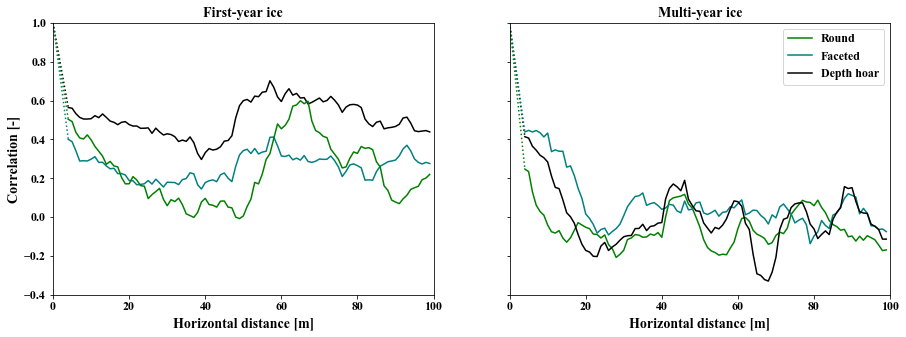

In [30]:
# Figure 10 with caption
# 'Spatial auto-correlation by layer-type composition on FYI and MYI as estimated from classified SMP profiles. 
#  Dotted lines show assumed correlation at length scales less than 1 m where geolocation uncertainty of the profiles precludes analysis.'

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(15,5))
ax1.set_title("First-year ice", fontsize=axis_label_size)
ax2.set_title("Multi-year ice", fontsize=axis_label_size)
ax1.tick_params(axis='both', which='major', labelsize=axis_value_size)
ax2.tick_params(axis='both', which='major', labelsize=axis_value_size)

line_kws = dict(linestyle = '-',
                linewidth = 1.5)
# Missing data where distances are within GPS noise
ax1.plot([0,min_bin], [1,h_corr_fyi[0]], color = "black", linestyle = ':')
ax1.plot([0,min_bin], [1,f_corr_fyi[0]], color = "teal", linestyle = ':')
ax1.plot([0,min_bin], [1,r_corr_fyi[0]], color = "green", linestyle = ':')

# Plot correlation 
ax1.plot(lags, h_corr_fyi, color = "black", **line_kws)
ax1.plot(lags, f_corr_fyi, color = "teal", **line_kws)
ax1.plot(lags, r_corr_fyi, color = "green", **line_kws)

ax2.plot([0,min_bin], [1,h_corr_myi[0]], color = "black", linestyle = ':')
ax2.plot([0,min_bin], [1,f_corr_myi[0]], color = "teal", linestyle = ':')
ax2.plot([0,min_bin], [1,r_corr_myi[0]], color = "green", linestyle = ':')

ax2.plot(lags, r_corr_myi, label = 'Round', color = "green",  **line_kws)
ax2.plot(lags, f_corr_myi, label = 'Faceted', color = "teal",  **line_kws)
ax2.plot(lags, h_corr_myi, label = 'Depth hoar', color = "black",  **line_kws)

ax2.legend(fontsize=axis_value_size)
ax1.set_ylim(-.4, 1)
ax2.set_ylim(-.4, 1)

ax1.set_xlim(0, max_dist)
ax2.set_xlim(0, max_dist)

ax1.set_ylabel("Correlation [-]", fontsize=axis_label_size)
ax1.set_xlabel("Horizontal distance [m]", fontsize=axis_label_size)
ax2.set_xlabel("Horizontal distance [m]", fontsize=axis_label_size)

f.savefig('./output/figures/Fig10_scales_lowres.png', format='png')


In [31]:
# Lag at which correlation is maxed
np.argwhere(h_corr_fyi==np.max(h_corr_fyi))

array([[53]], dtype=int64)

In [32]:
# Max correlation beyond the 1 m.
np.max(h_corr_fyi)

0.7024559284089292